# Select depth frames to use for classification

In [1]:
import h5py
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
from toolz import concat, groupby, curry, get, valmap, compose, pluck, assoc, first
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from aging.organization.dataframes import get_age, get_experiment
from aging.organization.paths import ValidationPaths, FOLDERS
from sklearn.cluster import k_means

- Loop through all the data
- get age of each male ontogeny session
- build dataframe of (session, length, age)
- select a subset of frames from each session
- load, and save to validation folder

In [2]:
validation_paths = ValidationPaths()

In [3]:
files = list(filter(lambda f: 'ontogeny_male' in get_experiment(f), concat(f.glob('**/*results_00.h5') for f in FOLDERS)))

In [3]:
out = []
for f in tqdm(files):
    age = get_age(f)
    try:
        with h5py.File(f, 'r') as h5f:
            length = len(h5f['frames'])
        out.append({'age': age, 'length': length, 'session': f})
    except OSError:
        pass
out = pd.DataFrame(out)

  0%|          | 0/615 [00:00<?, ?it/s]

In [4]:
sample = out.groupby('age').sample(n=5, random_state=0)

In [5]:
len(sample) * 3500

490000

In [8]:
aggregate = []
for _, row in tqdm(sample.iterrows()):
    with h5py.File(row['session'], 'r') as h5f:
        indices = np.sort(np.random.choice(row.length, 3500, replace=False))
        frames = h5f['win_size_norm_frames_v6'][()]
        raw_frames = h5f['frames'][()]
        aggregate.append(dict(frames=frames[indices], age=row.age, raw_frames=raw_frames[indices], session=row.session))

0it [00:00, ?it/s]

In [15]:
# group aggregate by age
aggregate_grouped = groupby(curry(get)('age'), aggregate)

In [18]:
joblib.dump(aggregate_grouped, '/n/scratch3/users/w/wg41/tmp/age-classification-frames-pre-processed.p', compress=3)

['/n/scratch3/users/w/wg41/tmp/age-classification-frames-pre-processed.p']

In [3]:
aggregate_grouped = joblib.load('/n/scratch3/users/w/wg41/tmp/age-classification-frames-pre-processed.p')

In [4]:
def flatten(x):
    return x.reshape(len(x), -1)


def subsample(data, subset=200, seed=0):
    np.random.seed(seed)
    sample = []
    for k, v in data.items():
        sample.append(v[np.random.permutation(len(v))[:subset]])
    return np.concatenate(sample, axis=0)


def multi_stage_pca(data, subset_frames=200, seed=0):

    train = subsample(valmap(age_concat, data), subset=subset_frames, seed=seed)
    pca = PCA(n_components=10).fit(flatten(train))

    apply_pca = compose(pca.transform, flatten)

    def update(d):
        return assoc(d, 'pca', apply_pca(d['frames']))

    pcs = valmap(
        lambda l: list(map(update, l)),
        data,
    )
    return pcs


def age_concat(d):
    return np.concatenate(list(pluck('frames', d)), axis=0)

In [5]:
pcs = multi_stage_pca(aggregate_grouped, subset_frames=200, seed=0)

In [6]:
list(pcs[3][0])

['frames', 'age', 'raw_frames', 'session', 'pca']

In [7]:
centroid, labels, inertia = k_means(
    np.concatenate(list(pluck('pca', concat(pcs.values()))), axis=0), n_clusters=13, random_state=0, n_init='auto'
)
labels = labels.reshape(-1, 3500)

In [8]:
i = 0
for k, v in pcs.items():
    for d in v:
        d['label'] = labels[i]
        i += 1

In [9]:
lc_df = {}
for age, v in pcs.items():
    label_counts = pd.Series(list(concat(pluck('label', v)))).value_counts()
    lc_df[age] = label_counts
lc_df = pd.DataFrame(lc_df).fillna(0)

In [10]:
# sample the minimum number of frames per age from each class
min_frames = lc_df.T.min()

<Axes: >

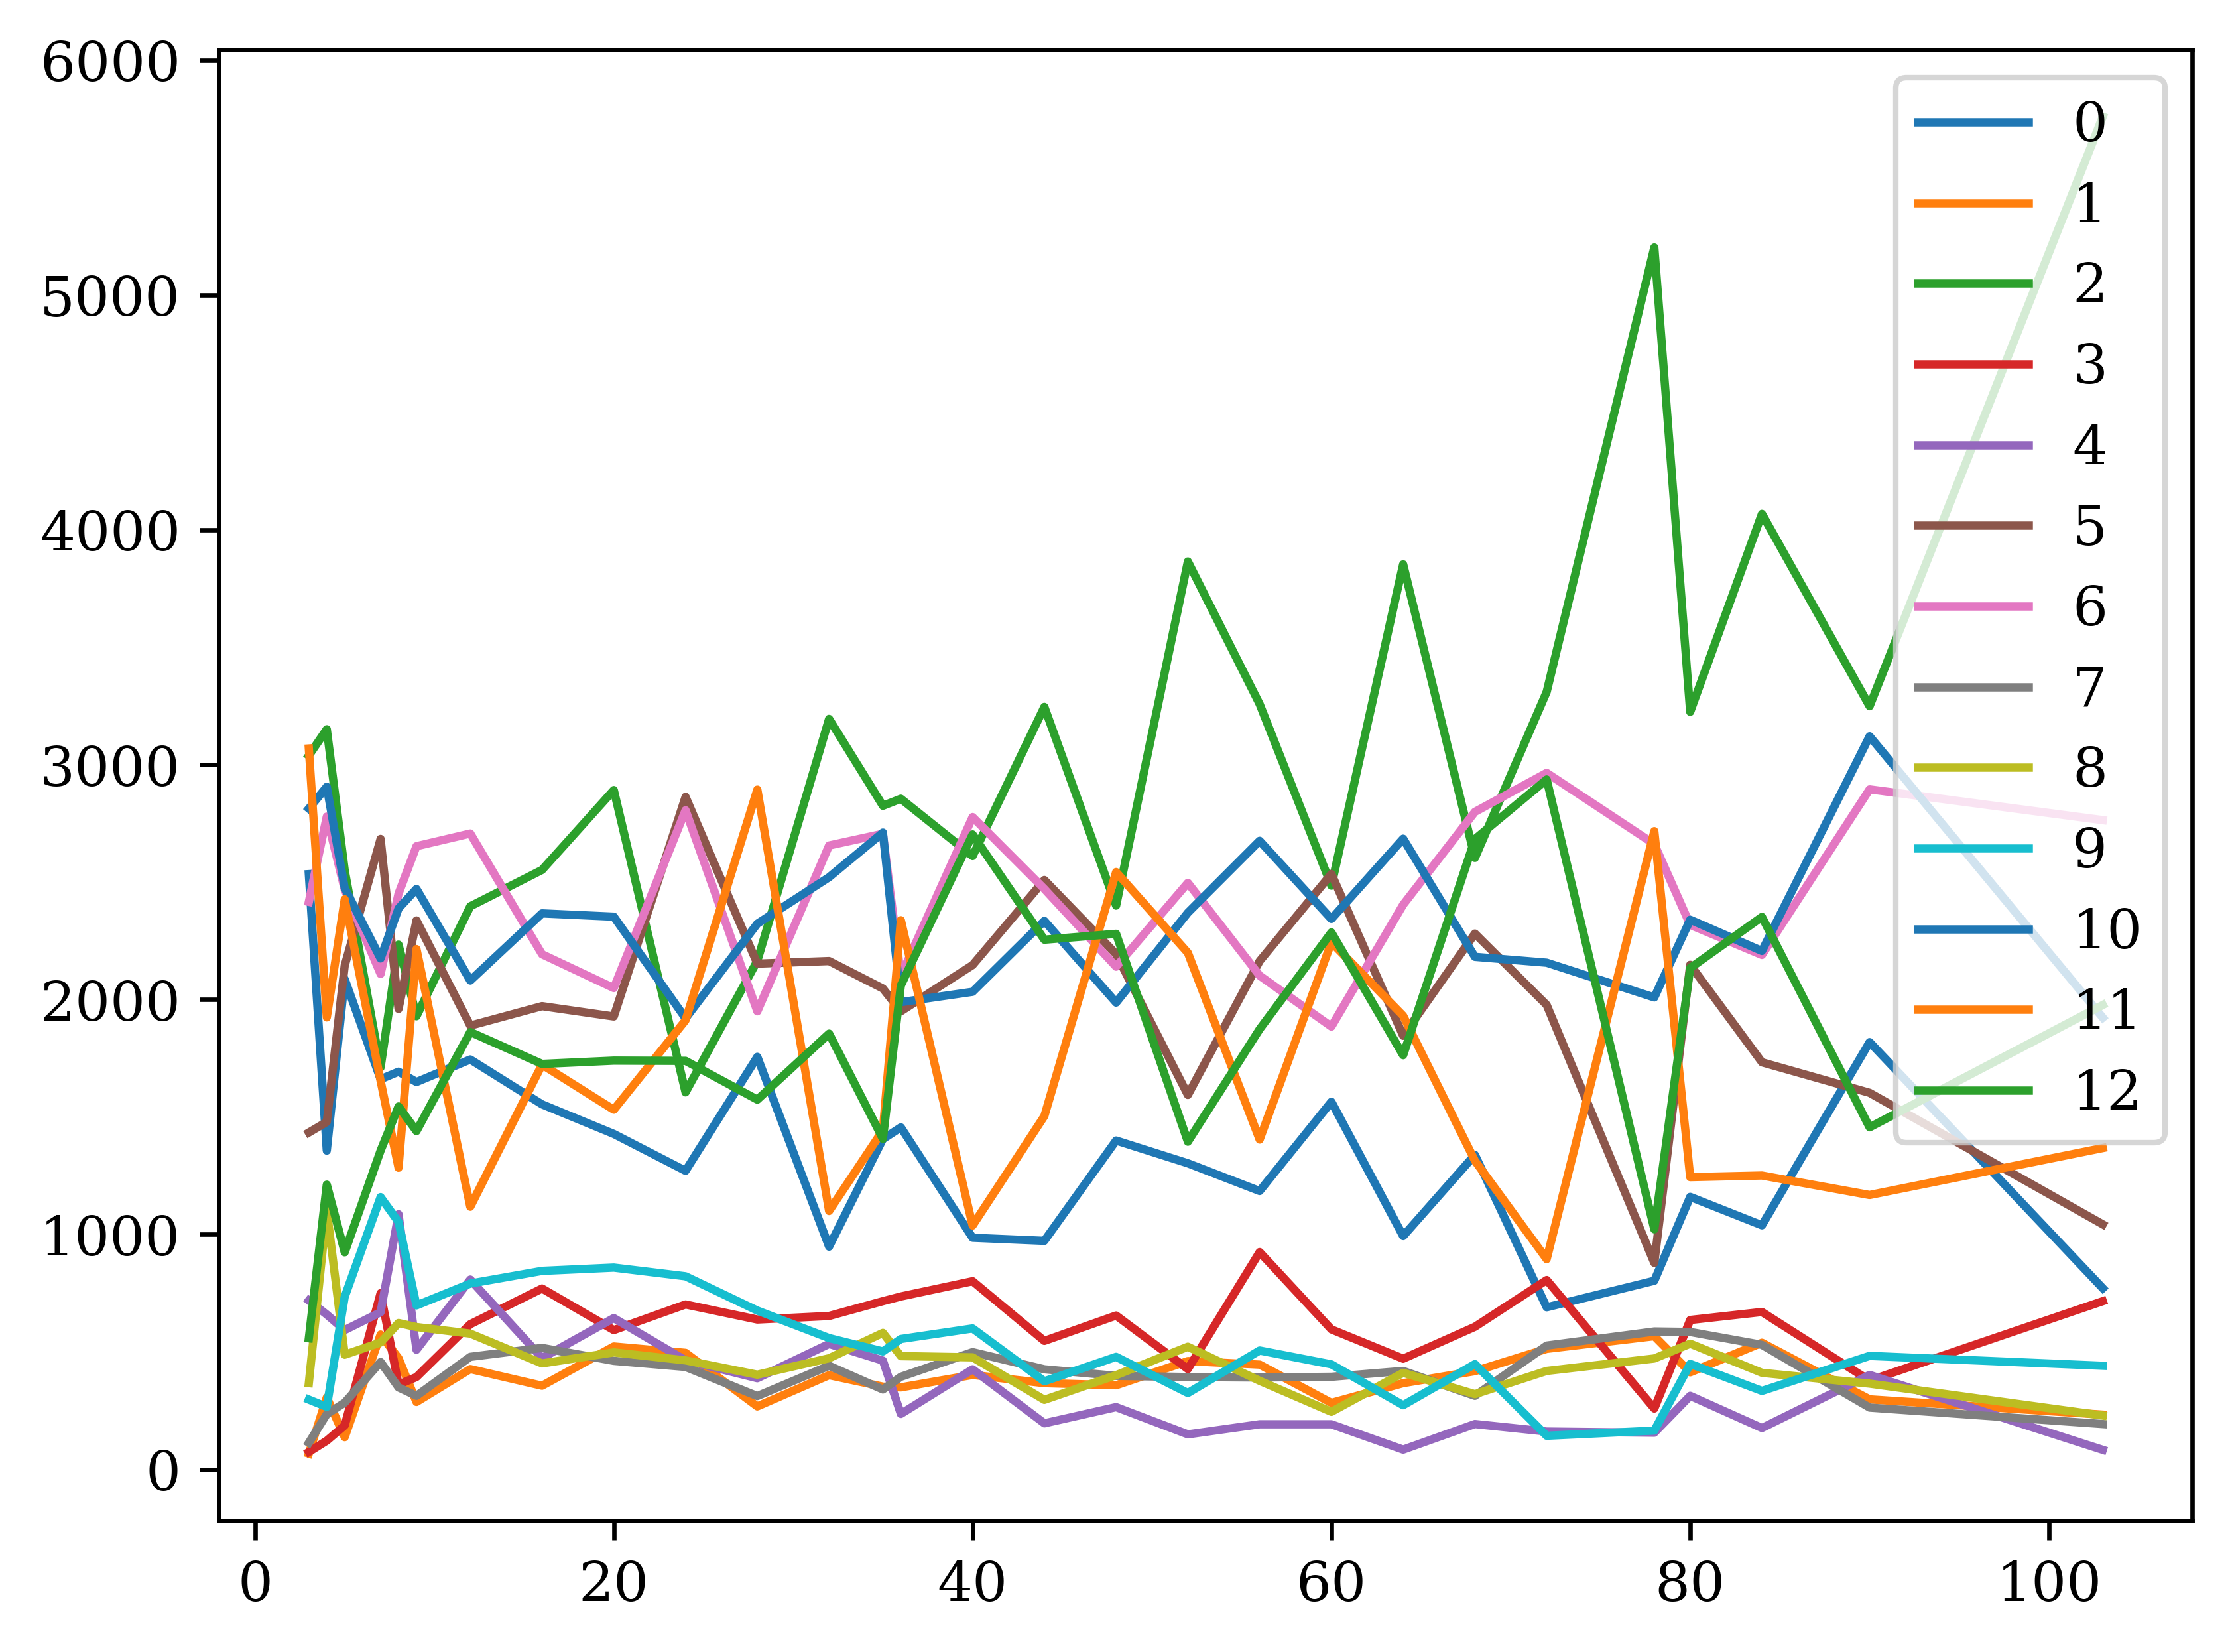

In [11]:
lc_df.T.plot()

In [12]:
list(pcs[3][0])

['frames', 'age', 'raw_frames', 'session', 'pca', 'label']

In [13]:
# create dataframe for sampling
sampling_df = []
for age, v in pcs.items():
    for d in v:
        tmp_df = pd.DataFrame({'label': d['label'], 'session': d['session'], 'frame_index': np.arange(len(d['label'])), 'age': age})
        sampling_df.append(tmp_df)
sampling_df = pd.concat(sampling_df, ignore_index=True)

In [14]:
sampling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490000 entries, 0 to 489999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        490000 non-null  int32 
 1   session      490000 non-null  object
 2   frame_index  490000 non-null  int64 
 3   age          490000 non-null  int64 
dtypes: int32(1), int64(2), object(1)
memory usage: 13.1+ MB


In [15]:
final_samples = []
for lbl, min_count in min_frames.items():
    tmp = sampling_df.query('label == @lbl').groupby('age').sample(n=min_count, random_state=0)
    final_samples.append(tmp)
final_samples = pd.concat(final_samples).sort_index()

In [16]:
final_samples.head()

,label,session,frame_index,age
0,12,/n/groups/datta/Dana/Ontogeny/raw_data/Dana_on...,0,3
2,12,/n/groups/datta/Dana/Ontogeny/raw_data/Dana_on...,2,3
3,6,/n/groups/datta/Dana/Ontogeny/raw_data/Dana_on...,3,3
4,12,/n/groups/datta/Dana/Ontogeny/raw_data/Dana_on...,4,3
5,12,/n/groups/datta/Dana/Ontogeny/raw_data/Dana_on...,5,3


In [22]:
final_sample_aggregate = {}
for (age, session), _df in final_samples.groupby(['age', 'session']):
    search = pcs[age]
    tmp = first(filter(lambda d: d['session'] == session, search))
    final_sample_aggregate[(age, session)] = tmp['raw_frames']

In [23]:
len(final_sample_aggregate)

140

In [26]:
joblib.dump(final_sample_aggregate, validation_paths.age_classifier, compress=('gzip', 3))

['/n/groups/datta/win/longtogeny/size_norm/validation_data/poses_for_age_classifier.p']